In [1]:
!pip install opencv-python
!pip install pillow

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym 
import random

from gym import Env, spaces
import time

from tkinter import *
from PIL import ImageTk

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [11]:
class LepScape(Env):
    def __init__(self):
        super(LepScape, self).__init__()
        
        
        #Define a 2-D observation space
        self.observation_shape=(800, 800, 3)
        self.observation_space = spaces.Box(low=np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Define an action space ranging from 0 to 5
        self.action_space = spaces.Discrete(7,)
        
        # Create a canvas to render the environment images upon
        self.canvas= np.ones(self.observation_shape) * 1
        
#         self.bg = cv2.imread("bg.jpg") / 255.0
#         self.bg_w = 800
#         self.bg_h = 800
#         self.bg = cv2.resize(self.bg, (self.bg_h, self.bg_w))
        
#         self.canvas[0 :  800, 0:800] = self.bg
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum bullets leprechaun can take at once
        self.max_bullets = 200
        
        # Permissible area of leprechaun to be
        #self.y_min = int (self.observation_shape[0] * 0.1)
        self.y_min = 0
        self.x_min = 0
        #self.y_max = int (self.observation_shape[0] * 0.9)
        self.y_max = self.observation_shape[0]
        self.x_max = self.observation_shape[1]
        
        # episode length in timesteps
        self.ep_length = 1000
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the leprechaun on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon
            
        

        text = 'bullets Left: {} | Rewards: {} | time left: {}'.format(self.bullets_left, self.ep_return, self.ep_length)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (255,255,255), 1, cv2.LINE_AA)
#         image = ImageTk.PhotoImage(file="images.jpeg")
#         self.canvas=cv2.create_image(10, 10, image=image, anchor=NW)

    def reset(self):
        #reset the time
        self.ep_length = 1000
        
        # Reset the bullets used
        self.bullets_left = self.max_bullets

        # Reset the reward
        self.ep_return  = 0

        # Number of bugs and ammo
        self.bug_count = 0
        self.ammo_count = 0

        # leprechaun spawns in bottom middle of the screen
        x = int(self.observation_shape[0]/2)
        y = self.y_max 
        
        #initialize background######################################################
        self.bg=Bg("bg",self.x_max, self.x_min, self.y_max, self.y_min)
        xbg=20
        ybg= 20
        self.bg.set_position(xbg, ybg)

        # Intialise the leprechaun
        self.leprechaun = Leprechaun("leprechaun", self.x_max, self.x_min, self.y_max, self.y_min)
        self.leprechaun.set_position(x,y)
        
       

        # Intialise the elements 
        self.elements = [self.bg, self.leprechaun]
        #self.elements = [self.leprechaun]

        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Game", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4:"shoot", 5: "Do Nothing"}
    
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False
    
    
    def step(self, action):
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the time 
        self.ep_length -= 1 

        # Reward for executing a step (agent gets small penalty  for continue to exist without completing the mission) .
        reward = -0.0001      

        # apply the action to the leprechaun
        if action == 0:
            self.leprechaun.move(0,5)
        elif action == 1:
            self.leprechaun.move(0,-5)
        elif action == 2:
            self.leprechaun.move(5,0)
        elif action == 3:
            self.leprechaun.move(-5,0)
        elif action == 4:
            if self.bullets_left>0:
                 # Spawn a bullet
                spawned_bullet = Bullet("bullet_{}".format(self.bullets_left), self.x_max, self.x_min, self.y_max, self.y_min)
                self.bullets_left -= 1

                bullet_x, bullet_y = self.leprechaun.get_position()
                spawned_bullet.set_position(bullet_x, bullet_y)

                # Append the spawned bullet to the elements currently present in Env. 
                self.elements.append(spawned_bullet) 
                spawned_bullet.move(0,-5)
                #small penalty for firing a bullet
                reward-=0.5
        elif action == 5:
            pass

        # Spawn a bug at the top edge with prob 0.01
        if random.random() < 0.01:

            # Spawn a bug
            spawned_bug = Bug("bug_{}".format(self.bug_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bug_count += 1

            # Compute the x,y co-ordinates of the position from where the bug has to be spawned
            # Horizontally, the position randomly and vertically, the bug is spawned at the top edge 
            # sampled from the set of permissible values            
            bug_x = random.randrange(self.x_min, self.x_max)
            bug_y = self.y_min
            spawned_bug.set_position(bug_x, bug_y)

            # Append the spawned bug to the elements currently present in Env. 
            self.elements.append(spawned_bug)    

        # Spawn an ammo pack at the top edge with prob 0.01
        if random.random() < 0.01:
            # Spawn an ammo pack
            spawned_ammo = Ammo("ammo_{}".format(self.ammo_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.ammo_count += 1

            # Compute the x,y co-ordinates of the position from where the ammo pack has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is at the top edge            
            ammo_x = random.randrange(self.x_min, self.x_max)
            ammo_y = self.y_min
            spawned_ammo.set_position(ammo_x, ammo_y)

            # Append the spawned ammo to the elemetns currently present in the Env.
            self.elements.append(spawned_ammo)   

        
        #check for bug collisions with bullet and update reward 
        current_bullets= [elem for elem in self.elements if isinstance(elem, Bullet)]
        current_bugs=[elem for elem in self.elements if isinstance(elem, Bug)]
        
        for elem in self.elements:
            if isinstance(elem, Bug):
                for bullet in current_bullets:
                    if self.has_collided(bullet, elem):
                        #remove the bug and the bullet from screen
                        print(elem, bullet)
                        #catch list removal errors#deal later
                        try: 
                            self.elements.remove(elem)
                            self.elements.remove(bullet)
                            reward +=5
                        except Exception as e:
                            print("element removal error", e)

        #update rest of elements                    
        for elem in self.elements:
            if isinstance(elem, Bug): 
                # If the bug has reached the bottom edge, remove it from the Env
                if elem.get_position()[1] >= self.y_max-elem.icon_w:
                    #print(elem.get_position()[1])
                    self.elements.remove(elem)
                else:
                    # Move the bug down by 5 pts.
                    #print(elem.get_position()[1],"down", self.y_max)
                    elem.move(0,5)

                # If the bug has collided with the leprechaun end the episode
                if self.has_collided(self.leprechaun, elem):
                    # Conclude the episode and remove the lep from the Env.
                    done = True
                    reward -=10
                    self.elements.remove(self.leprechaun)
                
                        

            if isinstance(elem, Ammo):
                # If the ammo pack has reached the bottom, remove it from the Env
                if elem.get_position()[1] >= self.y_max-elem.icon_w:
                    self.elements.remove(elem)
                else:
                    # Move the ammo down by 5 pts.
                    elem.move(0, 5)

                # If the ammo pack has collided with the leprechaun.
                if self.has_collided(self.leprechaun, elem):
                    # Remove the ammo pack from the env.
                    self.elements.remove(elem)

                    reward +=1
                    # update ammo left of the leprechaun to full.
                    self.bullets_left = self.max_bullets
            
            if isinstance(elem, Bullet):
                # If the bullet has reached the top edge, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the bullet up by 5 pts.
                    elem.move(0, -5)


        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of time, end the episode.
        if self.ep_length == 0:
            done = True

        return self.canvas, reward, done, []

In [12]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
        
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [13]:
class Leprechaun(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Leprechaun, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("lep2.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

    
class Bug(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bug, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bug.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
    
class Ammo(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Ammo, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("ammo.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Bullet(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bullet, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bullet.png") / 255.0
        self.icon_w = 10
        self.icon_h = 10
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Bg(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bg, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bg.jpg") / 255.0
        self.icon_w = x_max
        self.icon_h = y_max
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [14]:
# class LeprechaunBullet(Leprechaun):
#     def __init__(self, name, x_max, x_min, y_max, y_min):
#         super(Bullet, self).__init__(name, x_max, x_min, y_max, y_min)
#         self.icon = cv2.imread("bullet.png") / 255.0
#         self.icon_w = 32
#         self.icon_h = 32
#         self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


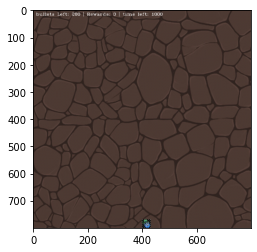

In [15]:
env = LepScape()
obs = env.reset()
screen = env.render(mode = "rgb_array")
plt.imshow(screen)

In [16]:
from IPython import display

env = LepScape()
obs = env.reset()

#try:
while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    # Render the game
    env.render()

    #     # Render the game
    #     screen=lambda : plt.imshow(env.render(mode = "rgb_array"))
    #     screen()

    if done == True:
        break
#except Exception as e:
  #print("An exception occurred", e)
  #env.close()


env.close()

<__main__.Bug object at 0x00000212BE33A580> <__main__.Bullet object at 0x00000212BD5A2D30>
<__main__.Bug object at 0x00000212BD5A2D30> <__main__.Bullet object at 0x00000212BE302DF0>
<__main__.Bug object at 0x00000212BE323CA0> <__main__.Bullet object at 0x00000212BE33A370>
<__main__.Bug object at 0x00000212BE323CA0> <__main__.Bullet object at 0x00000212BE33A340>
element removal error list.remove(x): x not in list


In [ ]:
# env = LepScape()
# obs = env.reset()

# for i in range(100):
#     env.step(env.action_space.sample())
#     plt.imshow(env.render(mode = "rgb_array"))